In [166]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams
import nltk

import scipy
from sklearn.model_selection import cross_validate

## Load data

In [22]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

# df = df[~df['tokens_str'].isna()]

# df['tokens'] = df['tokens_str'].progress_apply(
#     lambda x: x.split(' ') 
# #            .replace('ą', 'ą')
# #            .replace('ć', 'ć')
# #            .replace('ę', 'ę')
# #            .replace('ń', 'ń')
# #            .replace('ó', 'ó')
# #            .replace('ś', 'ś')
# #            .replace('ź', 'ź')
# #            .replace('ż', 'ż')
# )

In [23]:
df = df[ df['assestment'] != 'brak' ]

Na potrzeby Twojej pracy, wypowiedzi z oceną brak można odrzucić, zbity_zegar interpretować jako fałsz. Resztę danych w zależności od przyjętego modelu, jeśli ocena jest binarna to prawde i blisko_prawdy mozna polaczyc razem, tak samo jak raczej_falsz i falsz. Jeśli jednak ocena jest przedziałem to można pokusić się o przyjęcie wartości 1, 0.75, 0.5, 0.25, 0 zakładając ze 1 to prawda a 0 to pełny fałsz.
sub_title_text_after to komentarz do wypowiedzi, moze pomóc rozwiać wątpliwości co do tego jak oceniane są wartości połówkowe i bliskie pełnych

In [24]:
df['assestment'].value_counts()

Prawda               2831
falsz                1308
Fałsz                1136
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
Częściowy fałsz       9
Name: assestment, dtype: int64

In [25]:
df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

In [26]:
df['assestment'].value_counts()

Fałsz               3439
Prawda              3103
Manipulacja          968
Nieweryfikowalne     236
Name: assestment, dtype: int64

In [27]:
df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

In [28]:
df = df.reset_index(drop=True)

In [29]:
df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6542 entries, 0 to 6541
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   assestment         6542 non-null   int64  
 1   author             6512 non-null   object 
 2   text_clean         6542 non-null   object 
 3   TEXT_POS           6542 non-null   object 
 4   sentiment_all      6542 non-null   float64
 5   sentiment_avg      6542 non-null   float64
 6   uniq_words         6542 non-null   int64  
 7   uniq_lemm          6542 non-null   int64  
 8   err                6542 non-null   int64  
 9   net                6542 non-null   int64  
 10  ADJ                6542 non-null   float64
 11  ADV                6542 non-null   float64
 12  NOUN               6542 non-null   float64
 13  words_start_upper  6542 non-null   int64  
 14  words_full_upper   6542 non-null   int64  
 15  exclamation_marks  6542 non-null   int64  
 16  question_marks     6542 

In [110]:
id_train, id_test = train_test_split(
    df.index.values.tolist(), 
    test_size=0.33, 
    stratify = df['assestment'].values,
    random_state=0)

y_train = df.loc[id_train,:].copy()['assestment']

y_test = df.loc[id_test,:].copy()['assestment']

## Create POS ngrams embeddings

In [111]:
words =  sum(df.loc[id_train,:]['TEXT_POS'].str.split(' ').values.tolist(), [])

In [112]:
n1 = (pd.Series(nltk.ngrams(words, 1)).value_counts()) 
n2 = (pd.Series(nltk.ngrams(words, 2)).value_counts()) 
n3 = (pd.Series(nltk.ngrams(words, 3)).value_counts()) 

In [113]:
n1 = n1[n1>5]
n2 = n2[n2>5]
n3 = n3[n3>5]

In [114]:
print(
    n1.shape,
    n2.shape,
    n3.shape
)

(18,) (253,) (1681,)


In [153]:
X_train_df = df.loc[id_train,:].copy()

In [154]:
pos = {}
y = y_train.values

for n in tqdm(n1.index.tolist() + n2.index.tolist() + n3.index.tolist()):
    x = X_train_df['TEXT_POS'].str.count(' '.join(n)) / X_train_df['TEXT_POS'].str.split(' ').str.len()
    
    r = scipy.stats.pearsonr(x.values, y)[0]
    
    if r > 0.05:
        pos[' '.join(n)] = x
        pos[' '.join(n)].name = ' '.join(n)

100%|███████████████████████████████████████| 1952/1952 [01:26<00:00, 22.56it/s]


In [156]:
X_train_df = pd.concat( [X_train_df] + list( pos.values() ), axis=1 )

In [157]:
X_train_df.shape

(4383, 69)

In [158]:
col_use = ['sentiment_all', 'sentiment_avg', 'uniq_words', 'uniq_lemm', 'err', 'net', 'ADJ', 'ADV',
       'NOUN', 'words_start_upper', 'words_full_upper', 'exclamation_marks',
       'question_marks', 'upper_letters', 'chars', 'ADP', 'PROPN', 'X', 'NUM',
       'SYM', 'X PUNCT', 'PROPN VERB', 'NUM X', 'NUM NOUN', 'NUM SYM',
       'PART NUM', 'ADP NUM', 'PUNCT NUM', 'VERB NUM', 'NOUN NUM', 'SYM PUNCT',
       'NUM PROPN', 'SYM NOUN', 'AUX NUM', 'SYM PROPN', 'X NUM', 'NUM X PUNCT',
       'X PUNCT NOUN', 'NUM NOUN PUNCT', 'ADJ X PUNCT', 'ADP PROPN VERB',
       'PROPN VERB ADP', 'PART NUM X', 'NUM SYM PUNCT', 'PUNCT NUM X',
       'NUM NOUN ADP', 'ADP ADJ X', 'VERB NUM X', 'NOUN ADP NUM', 'NUM X NOUN',
       'NOUN NUM X', 'VERB PART NUM', 'PART NUM NOUN', 'NUM SYM NOUN',
       'ADP NOUN NUM', 'PUNCT NUM SYM', 'PROPN PROPN ADP', 'NUM SYM PROPN',
       'NOUN VERB NUM', 'ADP NUM SYM', 'PROPN PUNCT NUM', 'VERB NUM SYM',
       'PUNCT ADJ NUM', 'PUNCT CCONJ NUM', 'CCONJ NUM X']

In [159]:
X_test_df = df.loc[id_test,:].copy()

pos_test = {}

for n in tqdm(list(pos.keys())):
    x = X_test_df['TEXT_POS'].str.count(n) / X_test_df['TEXT_POS'].str.split(' ').str.len()
    
    pos_test[n] = x
    pos_test[n].name = n

X_test_df = pd.concat( [X_test_df] + list( pos_test.values() ), axis=1 )

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 53.13it/s]


In [161]:
logisticRegr = LogisticRegression(max_iter=1000)

X_train = X_train_df[col_use].sort_index().values
X_test = X_test_df[col_use].sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

LogisticRegression(max_iter=1000)

In [165]:
train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2304
           1       0.64      0.50      0.56      2079

    accuracy                           0.63      4383
   macro avg       0.63      0.63      0.62      4383
weighted avg       0.63      0.63      0.63      4383



## One-hot embeddings

In [12]:
df_one = df.copy()

df_one = df_one[['tokens']].reset_index().explode('tokens')
df_one['n'] = 1
df_one['tokens'] = df_one['tokens'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )

In [13]:
df_one_trn = df_one.loc[id_train,:].copy()
df_one_tst = df_one.loc[id_test,:].copy()

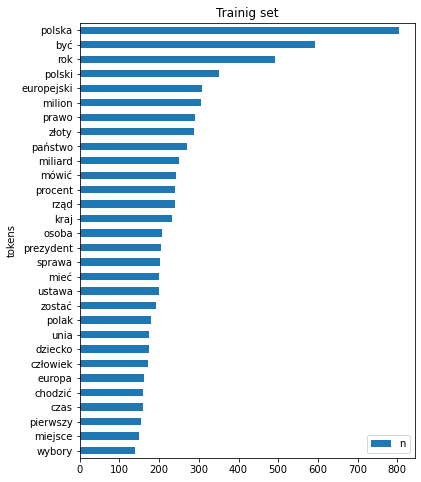

In [14]:
df_one_trn = df_one_trn[df_one_trn['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8));
df_one_trn.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Trainig set')
plt.show()

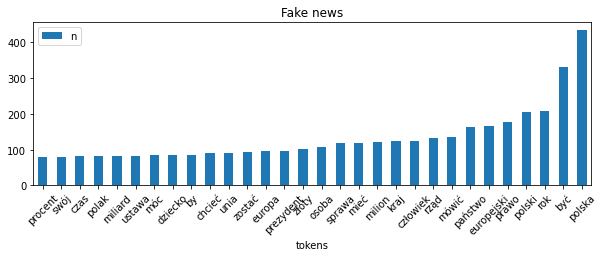

In [15]:
f, ax = plt.subplots(figsize=(10,3));
df_one_trn[
    df_one_trn['index'].isin(y_train[y_train==0].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Fake news')
plt.show()

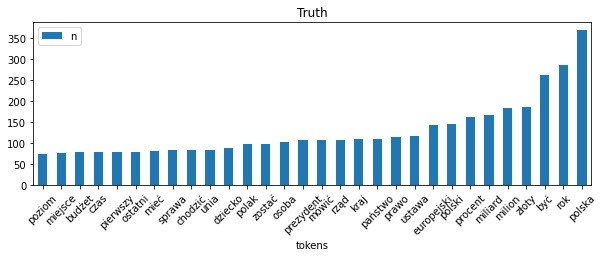

In [16]:
f, ax = plt.subplots(figsize=(10,3));
df_one_trn[
    df_one_trn['index'].isin(y_train[y_train==1].index.values)
].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='bar', ax=ax)
plt.xticks(rotation = 45) 
plt.title('Truth')
plt.show()

In [17]:
df_one_trn_p = df_one_trn.drop_duplicates().pivot(index='index', columns='tokens', values='n').fillna(0)
df_one_trn_p.shape

(4382, 10107)

In [18]:
df_one_trn_p = df_one_trn_p.loc[:, ~df_one_trn_p.columns.isin(['być', 'polska', 'rok'])]

In [19]:
df_one_trn_p = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 1)]
df_one_trn_p.shape

(4382, 4555)

In [20]:
df_one_trn_p_20 = df_one_trn_p.loc[:, (df_one_trn_p.sum() > 20)]
df_one_trn_p_20.shape

(4382, 446)

In [21]:
df_one_trn_p.columns.values

array(['abonament', 'aborcja', 'aborcyjny', ..., 'żądać', 'żłobek',
       'żłobk'], dtype=object)

In [22]:
df_one_tst_p = pd.merge(
    df_one_tst,
    pd.DataFrame({'tokens': df_one_trn_p.columns.values}),
    on='tokens',
    how='outer'
)
df_one_tst_p = df_one_tst_p.drop_duplicates().pivot(index='index', columns='tokens', values='n').fillna(0)
df_one_tst_p = df_one_tst_p[df_one_trn_p.columns.values]

df_one_tst_p = df_one_tst_p[df_one_tst_p.index.notna()]
df_one_tst_p.shape

(2159, 4555)

In [23]:
df_one_trn_p.shape

(4382, 4555)

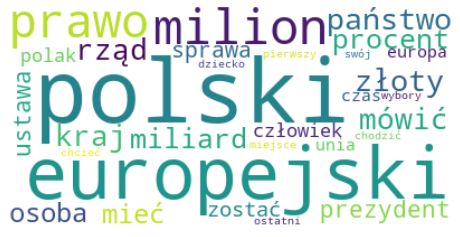

In [24]:
wordcloud = WordCloud(background_color='white',
                      max_words=30).generate_from_frequencies(df_one_trn_p.sum())

f, ax = plt.subplots(figsize=(8,8));
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
df_one_trn_p.shape

(4382, 4555)

In [57]:
def get_tfidf(df):
    tf = df.divide(df.sum(1).values, axis=0)
    idf = np.log10( (df.shape[0]+1)/(df.sum()+1) )
    tfidf = tf*idf
    gtf = np.log10( df.sum()+1 )
    tfidf_kindof = gtf * idf
    
    return tfidf, tfidf_kindof.sort_values(ascending=False)

In [58]:
tfidf_fn, tfidf_ko_fk =  get_tfidf(df_one_trn_p[y_train.sort_index()==0])
tfidf_t, tfidf_ko_t =  get_tfidf(df_one_trn_p[y_train.sort_index()==1])

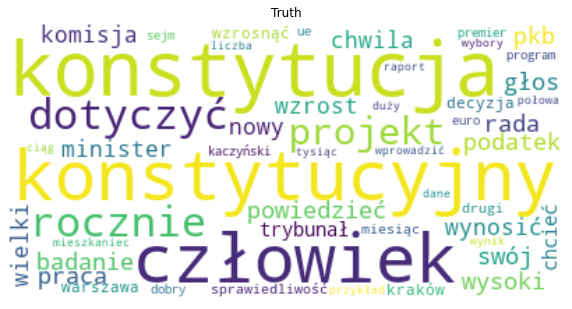

In [59]:
wordcloud = WordCloud(background_color='white',
                      max_words=50).generate_from_frequencies(tfidf_ko_t)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Truth')
plt.axis('off')
plt.show()

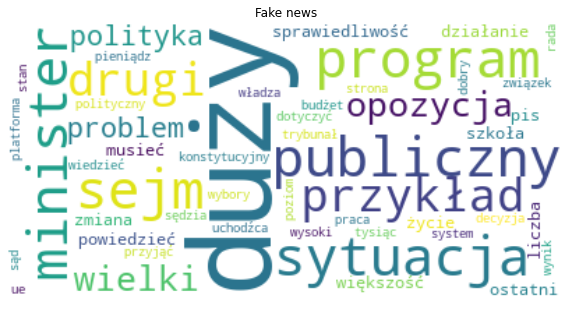

In [60]:
wordcloud = WordCloud(background_color='white',
                      max_words=50).generate_from_frequencies(tfidf_ko_fk)

f, ax = plt.subplots(figsize=(10,6));
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Fake news')
plt.axis('off')
plt.show()

In [38]:
logisticRegr = LogisticRegression()

X_train = df_one_trn_p.sort_index().values
X_test = df_one_tst_p.sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

LogisticRegression()

In [39]:
train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2303
           1       0.90      0.92      0.91      2079

    accuracy                           0.92      4382
   macro avg       0.92      0.92      0.92      4382
weighted avg       0.92      0.92      0.92      4382



In [40]:
test_predictions = logisticRegr.predict(X_test)

print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1135
           1       0.62      0.60      0.61      1024

    accuracy                           0.64      2159
   macro avg       0.64      0.64      0.64      2159
weighted avg       0.64      0.64      0.64      2159



In [48]:
df_one_tst_p_20 = pd.merge(
    df_one_tst,
    pd.DataFrame({'tokens': df_one_trn_p_20.columns.values}),
    on='tokens',
    how='outer'
)
df_one_tst_p_20 = df_one_tst_p_20.drop_duplicates().pivot(index='index', columns='tokens', values='n').fillna(0)
df_one_tst_p_20 = df_one_tst_p_20[df_one_trn_p_20.columns.values]

df_one_tst_p_20 = df_one_tst_p_20[df_one_tst_p.index.notna()]

logisticRegr_20 = LogisticRegression()

X_train_20 = df_one_trn_p_20.sort_index().values
X_test_20 = df_one_tst_p_20.sort_index().values

logisticRegr_20.fit(X_train_20, y_train.sort_index().values)

LogisticRegression()

In [49]:
train_predictions_20 = logisticRegr_20.predict(X_train_20)
print(classification_report(y_train.sort_index().values, train_predictions_20))

test_predictions_20 = logisticRegr_20.predict(X_test_20)
print(classification_report(y_test.sort_index().values, test_predictions_20))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71      2303
           1       0.68      0.65      0.66      2079

    accuracy                           0.69      4382
   macro avg       0.69      0.69      0.69      4382
weighted avg       0.69      0.69      0.69      4382

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1135
           1       0.61      0.56      0.59      1024

    accuracy                           0.62      2159
   macro avg       0.62      0.62      0.62      2159
weighted avg       0.62      0.62      0.62      2159



In [50]:
importance = logisticRegr.coef_[0]
importance_20 = logisticRegr_20.coef_[0]

importance.shape

(446,)

In [51]:
# https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
# https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X_train, y_train.sort_index().values)
scores, pvalues_20 = chi2(X_train_20, y_train.sort_index().values)

In [38]:
df_logreg_imp = pd.DataFrame(
    {
        'token' : df_one_trn_p.columns.values.tolist(),
        'coef': importance,
        'coef_abs': np.abs(importance),
        'pvalue' : pvalues
    }
)

In [52]:
df_logreg_imp_20 = pd.DataFrame(
    {
        'token' : df_one_trn_p_20.columns.values.tolist(),
        'coef': importance_20,
        'coef_abs': np.abs(importance_20),
        'pvalue' : pvalues_20
    }
)

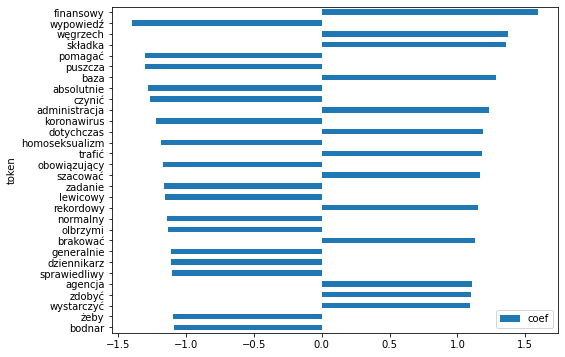

In [39]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp[df_logreg_imp['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

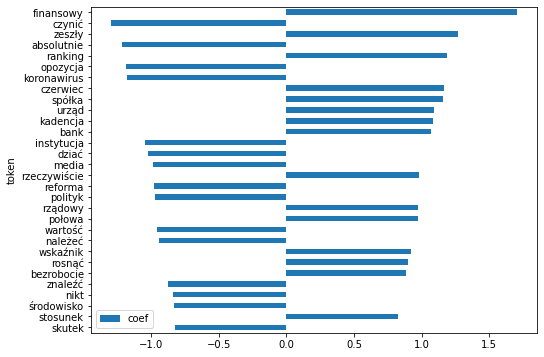

In [55]:
f, ax = plt.subplots(figsize=(8,6));

df_logreg_imp_20[df_logreg_imp_20['pvalue']<0.05].sort_values('coef_abs').tail(30)[['token', 'coef']].set_index('token').plot(kind='barh', ax=ax)
plt.show()

In [40]:
# masker = shap.maskers.Independent(data = X_train)
# explainer = explainer = shap.LinearExplainer(logisticRegr, masker)
# shap_values = explainer.shap_values(X_train)

# shap.summary_plot(shap_values, X_train)

### XGBoost

In [56]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train_20 , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train_20)
test_predictions = xgbc0.predict(X_test_20)

In [57]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2303
           1       0.76      0.68      0.72      2079

    accuracy                           0.74      4382
   macro avg       0.75      0.74      0.74      4382
weighted avg       0.75      0.74      0.74      4382



In [58]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1135
           1       0.63      0.54      0.58      1024

    accuracy                           0.63      2159
   macro avg       0.63      0.63      0.63      2159
weighted avg       0.63      0.63      0.63      2159



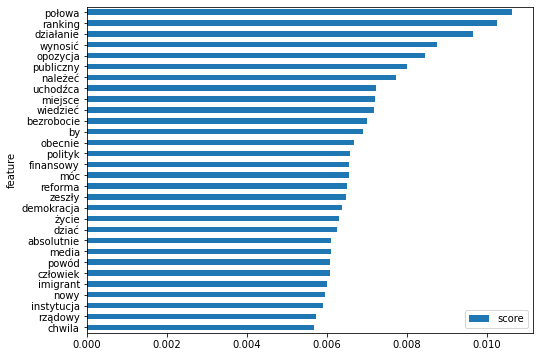

In [59]:
#plotting feature importance
features_list = df_one_trn_p_20.columns.values.tolist()

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').tail(30).plot(kind='barh', ax=ax)
plt.show()

### TfIdf approach

In [67]:
logisticRegr = LogisticRegression()

# cols = df_logreg_imp.sort_values('coef_abs').tail(2000)['token'].values
tfidf, _ =  get_tfidf(df_one_trn_p)
tfidf_tst, _ =  get_tfidf(df_one_tst_p)

X_train = tfidf.sort_index().values
X_test = tfidf_tst.sort_index().values

logisticRegr.fit(X_train, y_train.sort_index().values)

train_predictions = logisticRegr.predict(X_train)

print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2303
           1       0.84      0.76      0.80      2079

    accuracy                           0.82      4382
   macro avg       0.82      0.82      0.82      4382
weighted avg       0.82      0.82      0.82      4382



In [76]:
X_test[np.isnan(X_test)] = 0

In [78]:
test_predictions = logisticRegr.predict(X_test)

print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69      1135
           1       0.65      0.56      0.60      1024

    accuracy                           0.65      2159
   macro avg       0.65      0.65      0.64      2159
weighted avg       0.65      0.65      0.65      2159



## Investigate ngrams

In [96]:
df_trn_p_fn = df_one_trn[df_one_trn['index'].isin(y_train[y_train==0].index)]
df_trn_p_t = df_one_trn[df_one_trn['index'].isin(y_train[y_train==1].index)]

In [100]:
bigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 2))
trigrams_fn = nltk.FreqDist(ngrams(df_trn_p_fn['tokens'].values, 3))

bigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 2))
trigrams_t = nltk.FreqDist(ngrams(df_trn_p_t['tokens'].values, 3))

In [98]:
bigrams_fn.most_common(20)

[(('unia', 'europejski'), 65),
 (('trybunał', 'konstytucyjny'), 35),
 (('miliard', 'złoty'), 34),
 (('komisja', 'europejski'), 29),
 (('donald', 'tusk'), 27),
 (('być', 'by'), 26),
 (('mieć', 'być'), 26),
 (('prawo', 'sprawiedliwość'), 23),
 (('na', 'przykład'), 23),
 (('milion', 'złoty'), 22),
 (('ostatni', 'rok'), 21),
 (('by', 'być'), 20),
 (('platforma', 'obywatelski'), 18),
 (('jarosław', 'kaczyński'), 16),
 (('wielki', 'brytania'), 16),
 (('być', 'być'), 16),
 (('państwo', 'członkowski'), 15),
 (('wymiar', 'sprawiedliwość'), 15),
 (('chcieć', 'by'), 14),
 (('miejsce', 'praca'), 14)]

In [101]:
bigrams_t.most_common(20)

[(('miliard', 'złoty'), 80),
 (('unia', 'europejski'), 73),
 (('milion', 'złoty'), 45),
 (('trybunał', 'konstytucyjny'), 35),
 (('prawo', 'sprawiedliwość'), 33),
 (('na', 'przykład'), 29),
 (('ostatni', 'rok'), 26),
 (('mieć', 'być'), 24),
 (('przyp', 'red'), 22),
 (('wielki', 'brytania'), 20),
 (('miliard', 'euro'), 19),
 (('jarosław', 'kaczyński'), 17),
 (('procent', 'polak'), 16),
 (('ciąg', 'ostatni'), 16),
 (('stany', 'zjednoczone'), 15),
 (('andrzej', 'duda'), 14),
 (('lech', 'kaczyński'), 14),
 (('bronisław', 'komorowski'), 13),
 (('donald', 'tusk'), 13),
 (('między', 'innymi'), 13)]

In [99]:
trigrams_fn.most_common(20)

[(('chcieć', 'by', 'być'), 10),
 (('krajowy', 'rada', 'sądownictwo'), 8),
 (('kraj', 'unia', 'europejski'), 7),
 (('jan', 'paweł', 'ii'), 6),
 (('rząd', 'platforma', 'obywatelski'), 6),
 (('ciąg', 'ostatni', 'rok'), 6),
 (('rząd', 'prawo', 'sprawiedliwość'), 5),
 (('dziecko', 'zespół', 'down'), 5),
 (('mieć', 'być', 'czynić'), 5),
 (('rząd', 'donald', 'tusk'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('prezydent', 'andrzej', 'duda'), 4),
 (('ii', 'wojna', 'światowy'), 4),
 (('premier', 'beata', 'szydło'), 4),
 (('trybunał', 'sprawiedliwość', 'ue'), 4),
 (('warszawa', 'przyp', 'red'), 4),
 (('przewodniczący', 'rada', 'europejski'), 4),
 (('zgodnie', 'prawo', 'międzynarodowy'), 3),
 (('bliskiego', 'wschód', 'afryka'), 3),
 (('wschód', 'afryka', 'północny'), 3)]

In [102]:
trigrams_t.most_common(20)

[(('ciąg', 'ostatni', 'rok'), 10),
 (('rząd', 'prawo', 'sprawiedliwość'), 10),
 (('kraj', 'unia', 'europejski'), 10),
 (('kwota', 'wolny', 'podatek'), 7),
 (('prezydent', 'bronisław', 'komorowski'), 6),
 (('hanna', 'gronkiewicz', 'waltz'), 6),
 (('plan', 'zagospodarować', 'przestrzenny'), 6),
 (('wysoki', 'izba', 'kontrola'), 5),
 (('chcieć', 'by', 'być'), 5),
 (('spółka', 'skarb', 'państwo'), 5),
 (('narodowy', 'bank', 'polska'), 5),
 (('miliard', 'złoty', 'budżet'), 5),
 (('międzynarodowy', 'fundusz', 'walutowy'), 5),
 (('główny', 'urząd', 'statystyczny'), 5),
 (('prezydent', 'lech', 'kaczyński'), 5),
 (('najwyższ', 'izba', 'kontrola'), 5),
 (('prezydent', 'andrzej', 'duda'), 5),
 (('procent', 'polak', 'uważać'), 4),
 (('milion', 'złoty', 'rocznie'), 4),
 (('program', 'in', 'vitro'), 4)]